## Practice photometry on PAL5 data

This notebook is to practice completeing photometry on real world data - it starts by reading in the FITS data:

In [1]:
import photutils # photometry package
import matplotlib.pyplot as plt
import numpy as np
import math
from astropy.io import fits # fits file management
from astropy.visualization import simple_norm
from astropy.visualization import astropy_mpl_style
from astropy.stats import sigma_clipped_stats
from astropy.table import Table

In [3]:
image = 'PAL5_data\PAL5_3p6um.fits'

fits.info(image)

Filename: PAL5_data\PAL5_3p6um.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   (1415, 697)   float32   


In [20]:
plt.style.use(astropy_mpl_style)

In [5]:
image_data = fits.getdata(image, ext = 0)
print(image_data.shape)

(697, 1415)


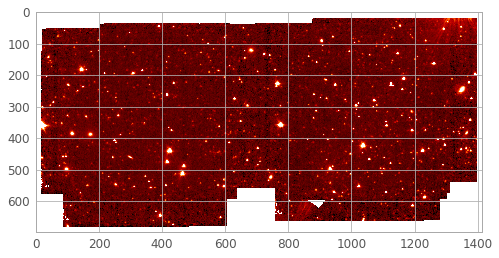

In [24]:
norm = simple_norm(image_data, 'sqrt', percent=99)
plt.imshow(image_data, norm=norm, interpolation='nearest')

Now convert the flux data in the FITS file into counts:

In [7]:
hdu_list = fits.open(image)
hdr = hdu_list[0].header
#print(hdr)

fluxconv = hdr['FLUXCONV']
gain = hdr['GAIN']
exptime = hdr['EXPTIME']
print(fluxconv, gain, exptime)
hdu_list.close()

convdata = image_data * exptime / fluxconv

0.1469 3.71 969.101928711
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


Now use source detection to detect the sources in the image: before this, the correct sigma value must be determined by plotting the number of stars (length of sources) against the sigma value

C:\Users\lukeb\Anaconda3\lib\site-packages\photutils\detection\findstars.py:453: RuntimeWarning: divide by zero encountered in double_scalars
  return ((self.conv_peak / self.cutout.threshold_eff) -


Text(0, 0.5, 'Number of stars')

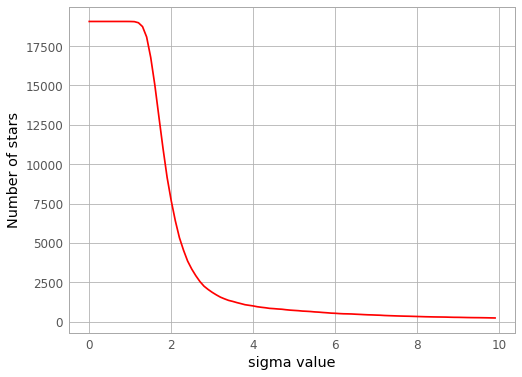

In [28]:
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder

data = convdata

Nstar = []
sigma_var = []

for n in range(100):
    mean, median, std = sigma_clipped_stats(data, sigma = n / 10)
    sigma_var.append(n * 0.1)
    sigma = n * 0.1
    daofind = DAOStarFinder(fwhm = 3.0, threshold = sigma*std)
    sources = daofind(data - median)
    Nstar.append(len(sources))

#print(Nstar)
#print(sigma_var)
plt.plot(sigma_var, Nstar, c='r')
plt.xlabel(r'sigma value')
plt.ylabel(r'Number of stars')
#mean, median, std = sigma_clipped_stats(data, sigma = 3.0)
#print((mean, median, std))

In [12]:
from photutils import DAOStarFinder

data = convdata

mean, median, std = sigma_clipped_stats(data, sigma = 4.)

print((mean, median, std))

daofind = DAOStarFinder(fwhm = 3.0, threshold = 4.*std)
sources = daofind(data - median)
for col in sources.colnames:
    sources[col].info.format = '%.8g'
print(sources)

(328.6638488769531, 316.47125244140625, 90.65550994873047)
 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag     
--- --------- --------- ---------- ... --- --------- --------- ------------
  1  1374.715  21.00836 0.43726052 ...   0 1610.6375 1.2222785  -0.21792547
  2 1306.2872 21.691519 0.47165577 ...   0 1589.3313 1.1566267  -0.15798301
  3 1193.3978 26.582374 0.58231789 ...   0 360.96375 1.0365852 -0.039012538
  4  875.5912 26.690492 0.46112195 ...   0 321.64923 1.0629436 -0.066275535
  5 1269.2458 28.561557 0.53767947 ...   0 2151.7273  3.953749   -1.4925227
  6 929.15178 29.723225 0.47614501 ...   0 440.39319 1.0941015 -0.097644058
  7 1140.0222 29.913012 0.51403425 ...   0 2029.8997 4.0161901   -1.5095356
  8 1302.2448 30.489824 0.51394185 ...   0 4173.6499 7.4491425   -2.1802657
  9 890.49164 34.446212 0.57750132 ...   0 485.06079 1.3705965  -0.34227402
 10 989.51277 35.887709 0.48979094 ...   0 479.91724  1.131855  -0.13447699
...       ...       ...      

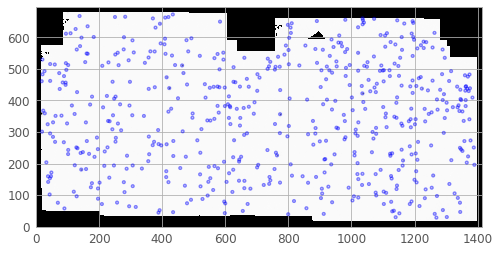

In [32]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch = SqrtStretch())

plt.imshow(data, cmap = 'Greys', origin = 'lower', norm = norm, interpolation = 'nearest')
apertures.plot(color = 'blue', lw = 1.5, alpha = 0.5)

Now performing annulus photometry on the data set:

In [11]:
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=6.)
annulus_apertures = CircularAnnulus(positions, r_in=6, r_out=14)
annulus_masks = annulus_apertures.to_mask(method = 'center')
annulus_data = annulus_masks[0].multiply(data)
mask = annulus_masks[0].data
annulus_data_1d = annulus_data[mask > 0]

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)

phot = aperture_photometry(data, apertures)
phot['annulus_median'] = bkg_median
phot['aper_bkg'] = bkg_median * apertures.area
phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']

z
print(phot)


WARNING

 id  xcenter   ycenter  aperture_sum annulus_median  aper_bkg aper_sum_bkgsub
       pix       pix                                                         
--- --------- --------- ------------ -------------- --------- ---------------
  1  1374.715  21.00836          nan      767.60413 86813.981             nan
  2 1306.2872 21.691519          nan      941.07599 106433.19             nan
  3 1193.3978 26.582374    40170.307      418.83795 47369.456      -7199.1495
  4  875.5912 26.690492          nan      313.18938 35420.884             nan
  5 1269.2458 28.561557    92495.088      639.06165 72276.169       20218.918
  6 929.15178 29.723225    37404.056      294.53822 33311.488       4092.5678
  7 1140.0222 29.913012    68417.435      408.80429 46234.676       22182.759
  8 1302.2448 30.489824    157632.94      894.32312 101145.56       56487.382
  9 890.49164 34.446212    36457.077      312.03087  35289.86       1167.2173
 10 989.51277 35.887709    45001.038      316.91534 35842.281   

: Input data contains invalid values (NaNs or infs), which were automatically clipped. [astropy.stats.sigma_clipping]


In [18]:
flux_zeropoint = 280.9

counts_zeropoint = flux_zeropoint * exptime / fluxconv
negative_sum=[]
phot['apparent_mag'] = float('NaN')

for i in range(0, len(phot)):
    if phot['aper_sum_bkgsub'][i] >= 0:
        phot['apparent_mag'][i] = 2.5 * math.log10(counts_zeropoint / phot['aper_sum_bkgsub'][i])
    else:
        negative_sum.append(phot['id'][i])
        
print(phot)
print(negative_sum)

phot.write('table.txt', format='csv', overwrite=True)

 id  xcenter   ycenter  ...  aper_bkg aper_sum_bkgsub    apparent_mag   
       pix       pix    ...                                             
--- --------- --------- ... --------- --------------- ------------------
  1  1374.715  21.00836 ... 86813.981             nan                nan
  2 1306.2872 21.691519 ... 106433.19             nan                nan
  3 1193.3978 26.582374 ... 47369.456      -7199.1495                nan
  4  875.5912 26.690492 ... 35420.884             nan                nan
  5 1269.2458 28.561557 ... 72276.169       20218.918  4.905353715027483
  6 929.15178 29.723225 ... 33311.488       4092.5678  6.639758800064218
  7 1140.0222 29.913012 ... 46234.676       22182.759  4.804709622240937
  8 1302.2448 30.489824 ... 101145.56       56487.382  3.789869892264389
  9 890.49164 34.446212 ...  35289.86       1167.2173  8.001869172865026
 10 989.51277 35.887709 ... 35842.281       9158.7572  5.765157139373972
...       ...       ... ...       ...             .